In [1]:
import pandas as pd
import numpy as np

In [2]:
# Caminho para o arquivo CSV
caminho = r'C:\Users\rozana.martins\OneDrive - Mereo\Documentos\click_predict\ETL\df_tratado.csv'

# Leitura do arquivo CSV
df = pd.read_csv(caminho)

# Conta a quantidade de linhas e colunas
print(f'Quantidade de linhas: {df.shape[0]}')
print(f'Quantidade de colunas: {df.shape[1]}')

Quantidade de linhas: 1741344
Quantidade de colunas: 17


In [3]:
df.columns

Index(['purchase_datetime', 'order_id', 'client_id', 'purchase_weekday_flag',
       'purchase_time_period', 'first_purchase_flag', 'purchase_type',
       'tickets_quantity', 'total_value', 'trip_type', 'no_return_flag',
       'origin_departure', 'destination_departure', 'origin_return',
       'destination_return', 'bus_company_departure', 'bus_company_return'],
      dtype='object')

In [4]:
df.dtypes

purchase_datetime         object
order_id                  object
client_id                 object
purchase_weekday_flag       bool
purchase_time_period      object
first_purchase_flag         bool
purchase_type             object
tickets_quantity           int64
total_value              float64
trip_type                 object
no_return_flag              bool
origin_departure          object
destination_departure     object
origin_return             object
destination_return        object
bus_company_departure     object
bus_company_return        object
dtype: object

In [6]:
df.describe()

,tickets_quantity,total_value
count,1.741344e+06,1.741344e+06
mean,1.394209e+00,1.610925e+02
std,8.096860e-01,1.666552e+02
min,1.000000e+00,-3.656570e+03
25%,1.000000e+00,6.153000e+01
50%,1.000000e+00,1.141800e+02
75%,2.000000e+00,1.981800e+02
max,1.600000e+01,6.723930e+03


In [7]:
# 1) garantir dtype e ordenação correta (evita rótulo errado!)
df["purchase_datetime"] = pd.to_datetime(df["purchase_datetime"], errors="coerce")
df = df.sort_values(["client_id", "purchase_datetime"]).reset_index(drop=True)

In [8]:
# 2) próxima compra do MESMO cliente
df["next_purchase"] = df.groupby("client_id")["purchase_datetime"].shift(-1)

In [9]:
# 3) diferença em dias até a próxima compra
delta = (df["next_purchase"] - df["purchase_datetime"])
# usar total_seconds/86400 para lidar com horas e não truncar para inteiro cedo demais
df["days_to_next"] = delta.dt.total_seconds() / 86400.0

In [10]:
# 4) label: 1 se houve compra em até 7 dias; 0 caso contrário
df["label"] = (df["next_purchase"].notna() & (df["days_to_next"] <= 7)).astype(int)

"label" - comprou em até 7 dias (1,0) OK
"purchase_weekday_flag" - Indicador se a compra foi feita em dia útil (bool) -- cat OK
"purchase_time_period" - Período do dia da compra. -- cat
"first_purchase_flag" - Indica se a compra é a primeira do cliente (bool). --cat OK
"purchase_type" - Classificação da compra. --cat
"trip_type" - Classificação da viagem. --cat

In [18]:
df["first_purchase_flag"] = df["first_purchase_flag"].astype(int)
df["first_purchase_flag"].head()

0    1
1    1
2    0
3    1
4    1
Name: first_purchase_flag, dtype: int64

In [ ]:
df["purchase_weekday_flag"] = df["purchase_weekday_flag"].astype(int)
df["purchase_weekday_flag"].head()

0    0
1    0
2    1
3    1
4    0
Name: purchase_weekday_flag, dtype: int64

In [19]:
df["purchase_time_period"] = df["purchase_time_period"].astype('category').cat.codes
df["purchase_time_period"].value_counts()

purchase_time_period
3    673276
2    550151
1    441673
0     76244
Name: count, dtype: int64

In [20]:
df["purchase_type"] = df["purchase_type"].astype('category').cat.codes
df["purchase_type"].value_counts()

purchase_type
1    1252524
0     488820
Name: count, dtype: int64

In [21]:
df["trip_type"] = df["trip_type"].astype('category').cat.codes
df["trip_type"].value_counts()

trip_type
0    1564310
1     177034
Name: count, dtype: int64

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
df_analise = df[["label", "purchase_weekday_flag", "purchase_time_period", "first_purchase_flag", "purchase_type", "trip_type"]]

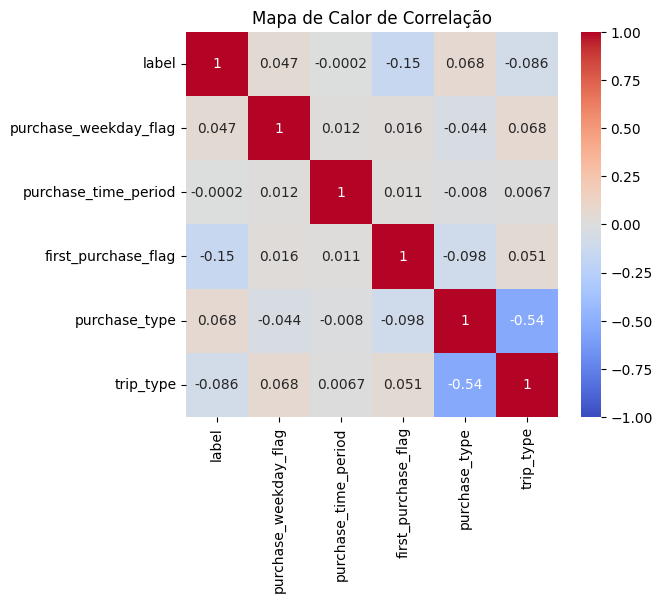

In [23]:
plt.figure(figsize=(6,5))
sns.heatmap(df_analise.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Mapa de Calor de Correlação")
plt.show()


In [24]:
# Definindo X e y
X = df_analise.drop("label", axis=1)
y = df_analise["label"]

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=45)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1393075, 5), (348269, 5), (1393075,), (348269,))

In [27]:
# Step 4: Create and train the first basic XGBoost model
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [28]:
# Step 5: Make predictions
y_pred = model.predict(X_test)

In [29]:
# Step 6: Evaluate the model's performance
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.78      1.00      0.87    270209
           1       0.00      0.00      0.00     78060

    accuracy                           0.78    348269
   macro avg       0.39      0.50      0.44    348269
weighted avg       0.60      0.78      0.68    348269



c:\Users\rozana.martins\OneDrive - Mereo\Documentos\click_predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rozana.martins\OneDrive - Mereo\Documentos\click_predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rozana.martins\OneDrive - Mereo\Documentos\click_predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

In [30]:
PARAMETERS = {"subsample":[0.5, 0.75, 1],
"colsample_bytree":[0.5, 0.75, 1],
"max_depth":[2, 6, 12],
"min_child_weight":[1,5,15],
"learning_rate":[0.3, 0.1, 0.03],
"n_estimators":[100]}

In [31]:
from sklearn.model_selection import GridSearchCV

model = XGBClassifier(n_estimators=100, n_jobs=-1, eval_metric='error')
"""Initialise Grid Search Model to inherit from the XGBoost Model,
set the of cross validations to 3 per combination and use accuracy
to score the models."""
model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=3,scoring="accuracy")

In [32]:
model_gs.fit(X_train,y_train)
print(model_gs.best_params_)

{'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5}


In [ ]:
#Initialise model using best parameters
model = XGBClassifier(objective="binary:logistic",subsample=0.5,
colsample_bytree=1,
min_child_weight=1,
max_depth=2,
learning_rate=0.3,
n_estimators=100)
#Fit the model but stop early if there has been no reduction in error after 10 epochs.
model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])

In [37]:

model = XGBClassifier(
    objective="binary:logistic",
    subsample=1,
    colsample_bytree=1,
    min_child_weight=1,
    max_depth=2,
    learning_rate=0.3,
    n_estimators=100,
    eval_metric="logloss"   # <-- aqui, no construtor
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)


[0]	validation_0-logloss:0.52476
[1]	validation_0-logloss:0.52085
[2]	validation_0-logloss:0.51850
[3]	validation_0-logloss:0.51727
[4]	validation_0-logloss:0.51648
[5]	validation_0-logloss:0.51591
[6]	validation_0-logloss:0.51553
[7]	validation_0-logloss:0.51533
[8]	validation_0-logloss:0.51514
[9]	validation_0-logloss:0.51505
[10]	validation_0-logloss:0.51499
[11]	validation_0-logloss:0.51494
[12]	validation_0-logloss:0.51491
[13]	validation_0-logloss:0.51489
[14]	validation_0-logloss:0.51486
[15]	validation_0-logloss:0.51485
[16]	validation_0-logloss:0.51484
[17]	validation_0-logloss:0.51483
[18]	validation_0-logloss:0.51481
[19]	validation_0-logloss:0.51481
[20]	validation_0-logloss:0.51481
[21]	validation_0-logloss:0.51480
[22]	validation_0-logloss:0.51480
[23]	validation_0-logloss:0.51479
[24]	validation_0-logloss:0.51479
[25]	validation_0-logloss:0.51479
[26]	validation_0-logloss:0.51477
[27]	validation_0-logloss:0.51477
[28]	validation_0-logloss:0.51477
[29]	validation_0-loglos

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [38]:
def model_eval(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

train_predictions = model.predict(X_train)
model_eval(y_train, train_predictions)

Accuracy: 0.7765669472210757
              precision    recall  f1-score   support

           0       0.78      1.00      0.87   1081811
           1       0.69      0.00      0.00    311264

    accuracy                           0.78   1393075
   macro avg       0.73      0.50      0.44   1393075
weighted avg       0.76      0.78      0.68   1393075



In [39]:
params = {'max_depth': [3, 6, 10, 15],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              'n_estimators': [100, 250, 500, 750],
              'reg_alpha' : [0.1,0.001,.00001],
              'reg_lambda': [0.1,0.001,.00001]
                     
              }

In [41]:
xgbclf = XGBClassifier(n_estimators=100, n_jobs=-1, objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss")

In [42]:
from sklearn.model_selection import RandomizedSearchCV

# RandomizedSearchCV
clf = RandomizedSearchCV(
    estimator=xgbclf,
    param_distributions=params,
    scoring="accuracy",
    n_iter=25,
    n_jobs=4,
    cv=5,
    verbose=1,
    random_state=42
)

# Rodar a busca
clf.fit(X_train, y_train)

print("Melhores parâmetros:", clf.best_params_)
print("Melhor score:", clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\rozana.martins\OneDrive - Mereo\Documentos\click_predict\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:21:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores parâmetros: {'subsample': np.float64(0.6), 'reg_lambda': 0.001, 'reg_alpha': 1e-05, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.4, 'colsample_bytree': np.float64(0.7), 'colsample_bylevel': np.float64(0.8999999999999999)}
Melhor score: 0.7765676650575166


In [4]:
#Initialise model using best parameters from randomized cv
model_new_hyper = XGBClassifier(
                                subsample=0.6,
reg_alpha=0.00001,  # L1 regularization (Lasso)
reg_lambda=0.01,  # L2 regularization (Ridge)
colsample_bytree=0.7,
colsample_bylevel=0.9,
min_child_weight=1,
max_depth=6,
learning_rate=0.4,
n_estimators=500,
scale_pos_weight=3.47,
tree_method="hist",
random_state=42)
#Fit the model but stop early if there has been no reduction in error after 10 epochs.
model_new_hyper.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

NameError: name 'XGBClassifier' is not defined

In [46]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score,
    average_precision_score, classification_report, confusion_matrix
)

y_proba = model_new_hyper.predict_proba(X_test)[:, 1]
y_pred  = model_new_hyper.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC (Average Precision):", average_precision_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5251544065076134
Balanced accuracy: 0.5972879933830781
ROC AUC: 0.6214109149548559
PR AUC (Average Precision): 0.2896048219698753

Classification report:
               precision    recall  f1-score   support

           0     0.8559    0.4665    0.6039    270209
           1     0.2828    0.7280    0.4073     78060

    accuracy                         0.5252    348269
   macro avg     0.5693    0.5973    0.5056    348269
weighted avg     0.7274    0.5252    0.5598    348269

Confusion matrix:
 [[126065 144144]
 [ 21230  56830]]


In [47]:
from sklearn.metrics import f1_score

ths = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(y_test, (y_proba >= t).astype(int), pos_label=1) for t in ths]
best_t = ths[int(np.argmax(f1s))]

print(f"Melhor threshold p/ F1 da classe 1: {best_t:.3f}  |  F1={max(f1s):.4f}")

y_pred_t = (y_proba >= best_t).astype(int)
print("\nReport no threshold ótimo:\n", classification_report(y_test, y_pred_t, digits=4))
print("Matriz (threshold ótimo):\n", confusion_matrix(y_test, y_pred_t))


Melhor threshold p/ F1 da classe 1: 0.450  |  F1=0.4075

Report no threshold ótimo:
               precision    recall  f1-score   support

           0     0.8601    0.4385    0.5809    270209
           1     0.2793    0.7531    0.4075     78060

    accuracy                         0.5090    348269
   macro avg     0.5697    0.5958    0.4942    348269
weighted avg     0.7299    0.5090    0.5420    348269

Matriz (threshold ótimo):
 [[118498 151711]
 [ 19272  58788]]


In [48]:
hist = model_new_hyper.evals_result()  # {'validation_0': {'auc': [...], 'logloss': [...]}, 'validation_1': {...}}
for split, metrics in hist.items():
    for m, vals in metrics.items():
        print(f"{split} | {m}  ->  última: {vals[-1]:.6f}  (épocas: {len(vals)})")


validation_0 | logloss  ->  última: 0.667707  (épocas: 500)


In [49]:
import pandas as pd

booster = model_new_hyper.get_booster()
gain = booster.get_score(importance_type="gain")   # ganho médio da divisão
cover = booster.get_score(importance_type="cover") # cobertura
weight = booster.get_score(importance_type="weight") # nº de vezes usada

# monta um DF ordenado por ganho
all_feats = set(gain)|set(cover)|set(weight)
rows = []
for f in all_feats:
    rows.append({
        "feature": f,
        "gain": gain.get(f, 0),
        "cover": cover.get(f, 0),
        "weight": weight.get(f, 0)
    })
fi = pd.DataFrame(rows).sort_values("gain", ascending=False)

# tenta trocar f0,f1,... pelos nomes reais (se disponíveis)
try:
    name_map = {f"f{i}": name for i, name in enumerate(model_new_hyper.feature_names_in_)}
    fi["feature"] = fi["feature"].map(lambda x: name_map.get(x, x))
except AttributeError:
    pass

print(fi.head(20))


                 feature        gain          cover  weight
2    first_purchase_flag  103.639305  115535.429688   705.0
4              trip_type   36.988529  127278.492188   633.0
0  purchase_weekday_flag   12.462994  117927.093750   691.0
1          purchase_type    7.298789  128273.171875   676.0
3   purchase_time_period    2.188549   99375.656250  1685.0


In [50]:
import pandas as pd
cv_df = pd.DataFrame(clf.cv_results_)
cols = ["mean_test_score", "std_test_score", "rank_test_score"] + [c for c in cv_df.columns if c.startswith("param_")]
print(cv_df[cols].sort_values("rank_test_score").head(10))
print("Melhores parâmetros:", clf.best_params_)
print("Melhor score (CV):", clf.best_score_)


    mean_test_score  std_test_score  rank_test_score  param_subsample  \
5          0.776568        0.000005                1              0.6   
1          0.776567        0.000005                2              0.5   
6          0.776567        0.000005                2              0.9   
3          0.776567        0.000005                2              0.6   
14         0.776567        0.000004                2              0.9   
8          0.776567        0.000005                2              0.6   
20         0.776566        0.000005                7              0.9   
19         0.776566        0.000006                7              0.6   
24         0.776566        0.000006                7              0.7   
15         0.776566        0.000007               10              0.5   

    param_reg_lambda  param_reg_alpha  param_n_estimators  param_max_depth  \
5              0.001          0.00001                 500                6   
1              0.001          0.10000   

In [ ]:
import numpy as np
import pandas as pd

client_id = df['client_id']

# 1) Probabilidades e rótulos
p_train = model_new_hyper.predict_proba(X_train)[:, 1]
p_test  = model_new_hyper.predict_proba(X_test)[:, 1]

# se quiser usar threshold customizado (ex.: 0.30):
threshold = 0.30
yhat_train = (p_train >= threshold).astype(int)
yhat_test  = (p_test  >= threshold).astype(int)

# 2) Monta DataFrames (mantém índice se X_* for DataFrame)
train_df = pd.DataFrame({
    "client_id": client_id,
    "set": "train",
    "y_true": np.asarray(y_train),
    "y_pred": yhat_train,
    "y_proba": p_train
}, index=getattr(X_train, "index", None))

test_df = pd.DataFrame({
    "client_id": client_id,
    "set": "test",
    "y_true": np.asarray(y_test),
    "y_pred": yhat_test,
    "y_proba": p_test
}, index=getattr(X_test, "index", None))

preds = pd.concat([train_df, test_df], axis=0)

# 3A) Salvar em CSV (tamanho maior)
preds.to_csv("predicoes_train_test.csv", index=True)

# 3B) OU salvar em Parquet (recomendado p/ volume grande)
#   requer pyarrow (pip install pyarrow)
#preds.to_parquet("predicoes_train_test.parquet", index=True)


In [1]:
import shap

c:\Users\rozana.martins\OneDrive - Mereo\Documentos\click_predict\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [3]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model_new_hyper)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

NameError: name 'model_new_hyper' is not defined